## Load Data example

In [ ]:
import pandas as pd

data = pd.read_csv("./data/SBA_loans_project_2.zip")
data = data.drop(columns=['index']) #Removing the index column

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.ensemble import GradientBoostingClassifier
import h2o
from h2o.estimators import H2OGradientBoostingEstimator
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from h2o.grid.grid_search import H2OGridSearch
import lightgbm as lgb
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from h2o.frame import H2OFrame
from h2o.model.metrics import H2OBinomialModelMetrics
from sklearn.metrics import accuracy_score
from h2o.metrics import H2OF1Score, H2OAUC


In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=123)

train_data, val_data = train_test_split(train_data, test_size=0.3, random_state=123)

data= train_data


In [ ]:
data.head()

City State    Zip                            Bank BankState  \
670727         WARNER    NH   3278           LEDYARD NATIONAL BANK        VT   
747876  MILLEDGEVILLE    GA  31061         FIRST WESTERN SBLC, INC        TX   
690335    CULVER CITY    CA  90232                  COMMUNITY BANK        CA   
138384      ROSEVILLE    MI  48066  JPMORGAN CHASE BANK NATL ASSOC        IL   
274759       TIVERTON    RI   2878        CITIZENS BANK NATL ASSOC        MA   

         NAICS  NoEmp  NewExist  CreateJob  RetainedJob  FranchiseCode  \
670727  446110      0       2.0          3            0              0   
747876       0     59       1.0          0            0          38600   
690335  541922      2       1.0          0            0              1   
138384       0      6       1.0          0            0              1   
274759  541611      2       1.0          0            0              1   

        UrbanRural RevLineCr LowDoc DisbursementGross BalanceGross  \
670727           2         N      N      $100,000.00        $0.00    
747876           1         N      N    $1,000,000.00        $0.00    
690335           1         0      Y      $115,000.00        $0.00    
138384           1         N      N      $175,000.00        $0.00    
274759           0         0      N       $18,000.00        $0.00    

                GrAppv      SBA_Appv  LoanInd  MIS_Status  
670727    $100,000.00    $90,000.00         5           0  
747876  $1,000,000.00   $750,000.00         5           1  
690335    $115,000.00    $97,750.00         3           0  
138384    $175,000.00   $157,500.00         5           0  
274759     $18,000.00     $9,000.00         6           0

In [ ]:
(data['MIS_Status'].value_counts()) / len(data) * 100

0    82.418416
1    17.581584
Name: MIS_Status, dtype: float64

In [ ]:
print(data['MIS_Status'].unique())

[0 1]


In [ ]:
data.isnull().sum()

City                   16
State                   6
Zip                     0
Bank                  746
BankState             749
NAICS                   0
NoEmp                   0
NewExist               68
CreateJob               0
RetainedJob             0
FranchiseCode           0
UrbanRural              0
RevLineCr            2297
LowDoc               1314
DisbursementGross       0
BalanceGross            0
GrAppv                  0
SBA_Appv                0
LoanInd                 0
MIS_Status              0
dtype: int64

In [ ]:
# Cleaning the train dataset
#There are no null values in these four columns, so I am going ahead and Converting the strings styled as '$XXXX.XX' to float values. Columns = ['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']
convertables = ['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']

for col in convertables:
    train_data[col] = train_data[col].str.replace('$', '')
    train_data[col] = train_data[col].str.replace(' ', '')
    train_data[col] = train_data[col].str.replace(',', '')

train_data = train_data.astype({'DisbursementGross': 'float', 'BalanceGross': 'float', 'GrAppv': 'float', 'SBA_Appv': 'float'})

# Removing records where RevLineCr not equals 'Y' or 'N' and LowDoc not equals 'Y' or 'N'
train_data = train_data[(train_data['RevLineCr'] == 'Y') | (train_data['RevLineCr'] == 'N')]
train_data = train_data[(train_data['LowDoc'] == 'Y') | (train_data['LowDoc'] == 'N')]

#Replacing Y with 1 and N with 0, in these two columns
train_data['RevLineCr'] = train_data['RevLineCr'].replace({'Y': 1, 'N': 0})
train_data['LowDoc'] = train_data['LowDoc'].replace({'Y': 1, 'N': 0})

#Franchise code, (00000 or 00001) = No franchise,(from data description),therefore I will create a new column called 'Franchise_Exists' where I can know just
#that franchise exists or not.
train_data.loc[(train_data['FranchiseCode'] <= 1), 'Franchise_Exists'] = 0
train_data.loc[(train_data['FranchiseCode'] > 1), 'Franchise_Exists'] = 1
train_data['Franchise_Exists'] = train_data['Franchise_Exists'].astype(int)
train_data = train_data.drop('FranchiseCode', axis=1)#drop franchise code

#cONVERTING NEWEXIST TO 0 AND 1'S ,
unique_values = train_data['NewExist'].unique()
valid_values = [val for val in unique_values if val in [1, 2]]
train_data = train_data[train_data['NewExist'].isin(valid_values)]
train_data['NewExist'] = train_data['NewExist'].replace({1.: 0, 2.: 1}).astype(int)

#Replacing null values
train_data.isnull().sum()
filler = {}
for col in train_data.drop(columns=['MIS_Status']).columns:
    if train_data[col].dtype == 'object':
        filler[col] = "UnKnown Value"
    else:
        filler[col] = 0

train_data.fillna(value=filler, inplace=True)
train_data.isnull().sum()

#FROM MY UNDERSTANDING OF THE NAICS CODES, THE FIRST TWO DIGITS SIGNIFY THE INDUSTRY RELATED TO THE BUSINESS,WHICH WHAT WE REQUIRE
#REPLACING NAICS COLUMN WITH FIRST TWO DIGITS AND DROPPING WHERE NAICS=0
# Replace NAICS values
train_data['NAICS'] = train_data['NAICS'].apply(lambda x: str(x)[:2] if x != 0 else 0)
train_data = train_data[train_data['NAICS'] != 0]
# let us create one feature where we have percentage of loan approved by SBA with respect to total Gross approved.
train_data['percent_approved'] = train_data['SBA_Appv'] / train_data['GrAppv']

scaler = StandardScaler()
cols_to_scale = ['SBA_Appv', 'GrAppv', 'NoEmp', 'RetainedJob', 'CreateJob', 'LoanInd', 'percent_approved','DisbursementGross','BalanceGross']
# Scaling the selected columns in feature datasets
train_data[cols_to_scale] = scaler.fit_transform(train_data[cols_to_scale])

target_encoder = ce.TargetEncoder(cols=["Zip", "City", "NAICS", 'Bank', 'BankState', 'State', 'UrbanRural','LowDoc','RevLineCr','Franchise_Exists','NewExist'])
train_data= target_encoder.fit_transform(train_data, train_data["MIS_Status"])

for col in ["Zip", "City", "NAICS", 'Bank', 'BankState', 'State', 'UrbanRural','LowDoc','RevLineCr','Franchise_Exists','NewExist']:
    new_col_name = col + "_trg"
    train_data.rename(columns={col: new_col_name}, inplace=True)



The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [ ]:
train_data.head()

City_trg  State_trg   Zip_trg  Bank_trg  BankState_trg  NAICS_trg  \
670727  0.193474   0.136480  0.198840  0.095788       0.055446   0.244045   
294737  0.407142   0.263163  0.443152  0.281013       0.296255   0.244045   
410384  0.164539   0.272342  0.219629  0.088545       0.096795   0.246253   
776245  0.149838   0.237234  0.112490  0.057781       0.192226   0.200663   
329525  0.207054   0.178093  0.222178  0.226640       0.193498   0.205845   

           NoEmp  NewExist_trg  CreateJob  RetainedJob  ...  RevLineCr_trg  \
670727 -0.164775      0.213822   0.063902    -0.273143  ...       0.181049   
294737 -0.098919      0.214197   0.179090    -0.046070  ...       0.259644   
410384 -0.033063      0.214197   0.121496     0.181003  ...       0.259644   
776245 -0.082455      0.214197   0.063902     0.010698  ...       0.259644   
329525 -0.148311      0.214197  -0.108881    -0.216375  ...       0.259644   

        LowDoc_trg  DisbursementGross  BalanceGross    GrAppv  SBA_Appv  \
670727    0.223624          -0.262288     -0.003165 -0.206851 -0.125808   
294737    0.223624          -0.571378     -0.003165 -0.534085 -0.512053   
410384    0.223624           0.233354     -0.003165 -0.206851 -0.313078   
776245    0.223624          -0.262288     -0.003165 -0.206851 -0.313078   
329525    0.223624          -0.314349     -0.003165 -0.457089 -0.465235   

         LoanInd  MIS_Status  Franchise_Exists_trg  percent_approved  
670727  0.002733           0              0.215896          1.380243  
294737 -1.339714           0              0.215896         -0.850075  
410384 -0.892232           0              0.215896         -0.850075  
776245  0.002733           0              0.215896         -0.850075  
329525  0.002733           1              0.215896         -0.850075  

[5 rows x 21 columns]

In [ ]:
# Cleaning and encoding the validation dataset

# Convert strings styled as '$XXXX.XX' to float values in specific columns
convertables = ['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']
for col in convertables:
    val_data[col] = val_data[col].str.replace('$', '')
    val_data[col] = val_data[col].str.replace(' ', '')
    val_data[col] = val_data[col].str.replace(',', '')
val_data = val_data.astype({'DisbursementGross': 'float', 'BalanceGross': 'float', 'GrAppv': 'float', 'SBA_Appv': 'float'})

# Removing records where RevLineCr not equals 'Y' or 'N' and LowDoc not equals 'Y' or 'N'
val_data = val_data[(val_data['RevLineCr'] == 'Y') | (val_data['RevLineCr'] == 'N')]
val_data = val_data[(val_data['LowDoc'] == 'Y') | (val_data['LowDoc'] == 'N')]

# Replace 'Y' with 1 and 'N' with 0 in these two columns
val_data['RevLineCr'] = val_data['RevLineCr'].replace({'Y': 1, 'N': 0})
val_data['LowDoc'] = val_data['LowDoc'].replace({'Y': 1, 'N': 0})

# Create a new column called 'Franchise_Exists' to determine if a franchise exists or not
val_data.loc[(val_data['FranchiseCode'] <= 1), 'Franchise_Exists'] = 0
val_data.loc[(val_data['FranchiseCode'] > 1), 'Franchise_Exists'] = 1
val_data['Franchise_Exists'] = val_data['Franchise_Exists'].astype(int)
val_data = val_data.drop('FranchiseCode', axis=1)

# Convert 'NewExist' column to 0 and 1
unique_values = val_data['NewExist'].unique()
valid_values = [val for val in unique_values if val in [1, 2]]
val_data = val_data[val_data['NewExist'].isin(valid_values)]
val_data['NewExist'] = val_data['NewExist'].replace({1.: 0, 2.: 1}).astype(int)

# Replacing null values
filler = {}
for col in val_data.drop(columns=['MIS_Status']).columns:
    if val_data[col].dtype == 'object':
        filler[col] = "UnKnown Value"
    else:
        filler[col] = 0
val_data.fillna(value=filler, inplace=True)

# Replace NAICS values with the first two digitd to identify industry
val_data['NAICS'] = val_data['NAICS'].apply(lambda x: str(x)[:2] if x != 0 else 0)
val_data = val_data[val_data['NAICS'] != 0]

# Creating a feature for the percentage of loan approved by SBA with respect to total Gross approved
val_data['percent_approved'] = val_data['SBA_Appv'] / val_data['GrAppv']

# Scaling selected columns in the dataset
cols_to_scale = ['SBA_Appv', 'GrAppv', 'NoEmp', 'RetainedJob', 'CreateJob', 'LoanInd', 'percent_approved', 'DisbursementGross', 'BalanceGross']
val_data[cols_to_scale] = scaler.transform(val_data[cols_to_scale])

#target encoding
val_data = target_encoder.transform(val_data)

for col in ["Zip", "City", "NAICS", 'Bank', 'BankState', 'State', 'UrbanRural', 'LowDoc', 'RevLineCr', 'Franchise_Exists', 'NewExist']:
    new_col_name = col + "_trg"
    val_data.rename(columns={col: new_col_name}, inplace=True)



The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [ ]:
#Cleaning and encoding test data
# Convert strings styled as '$XXXX.XX' to float values in specific columns
convertables = ['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']
for col in convertables:
    test_data[col] = test_data[col].str.replace('$', '')
    test_data[col] = test_data[col].str.replace(' ', '')
    test_data[col] = test_data[col].str.replace(',', '')
test_data = test_data.astype({'DisbursementGross': 'float', 'BalanceGross': 'float', 'GrAppv': 'float', 'SBA_Appv': 'float'})

# Removing records where RevLineCr not equals 'Y' or 'N' and LowDoc not equals 'Y' or 'N'
test_data = test_data[(test_data['RevLineCr'] == 'Y') | (test_data['RevLineCr'] == 'N')]
test_data = test_data[(test_data['LowDoc'] == 'Y') | (test_data['LowDoc'] == 'N')]

# Replacing 'Y' with 1 and 'N' with 0 in these two columns
test_data['RevLineCr'] = test_data['RevLineCr'].replace({'Y': 1, 'N': 0})
test_data['LowDoc'] = test_data['LowDoc'].replace({'Y': 1, 'N': 0})

# Create a new column called 'Franchise_Exists' to determine if a franchise exists or not
test_data.loc[(test_data['FranchiseCode'] <= 1), 'Franchise_Exists'] = 0
test_data.loc[(test_data['FranchiseCode'] > 1), 'Franchise_Exists'] = 1
test_data['Franchise_Exists'] = test_data['Franchise_Exists'].astype(int)
test_data = test_data.drop('FranchiseCode', axis=1)

# Convert 'NewExist' column to 0 and 1
unique_values = test_data['NewExist'].unique()
valid_values = [val for val in unique_values if val in [1, 2]]
test_data = test_data[test_data['NewExist'].isin(valid_values)]
test_data['NewExist'] = test_data['NewExist'].replace({1.: 0, 2.: 1}).astype(int)

# Replace null values
filler = {}
for col in test_data.drop(columns=['MIS_Status']).columns:
    if test_data[col].dtype == 'object':
        filler[col] = "UnKnown Value"
    else:
        filler[col] = 0
test_data.fillna(value=filler, inplace=True)

# Replace NAICS values
test_data['NAICS'] = test_data['NAICS'].apply(lambda x: str(x)[:2] if x != 0 else 0)
test_data = test_data[test_data['NAICS'] != 0]

# Creating a feature for the percentage of loan approved by SBA with respect to total Gross approved
test_data['percent_approved'] = test_data['SBA_Appv'] / test_data['GrAppv']

# Scale selected columns in the dataset
cols_to_scale = ['SBA_Appv', 'GrAppv', 'NoEmp', 'RetainedJob', 'CreateJob', 'LoanInd', 'percent_approved', 'DisbursementGross', 'BalanceGross']
test_data[cols_to_scale] = scaler.transform(test_data[cols_to_scale])

# Apply target encoding
test_data = target_encoder.transform(test_data)

for col in ["Zip", "City", "NAICS", 'Bank', 'BankState', 'State', 'UrbanRural', 'LowDoc', 'RevLineCr', 'Franchise_Exists', 'NewExist']:
    new_col_name = col + "_trg"
    test_data.rename(columns={col: new_col_name}, inplace=True)


The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [ ]:
test_data.head()

City_trg  State_trg   Zip_trg  Bank_trg  BankState_trg  NAICS_trg  \
649953  0.160001   0.167058  0.149963  0.133662       0.288637   0.200663   
779885  0.214098   0.113125  0.186242  0.133267       0.074534   0.143136   
436186  0.279020   0.322707  0.357613  0.183984       0.233301   0.245810   
668099  0.163121   0.138070  0.204767  0.323230       0.275977   0.103936   
783328  0.331348   0.273573  0.194552  0.323230       0.275977   0.232712   

           NoEmp  NewExist_trg  CreateJob  RetainedJob  ...  RevLineCr_trg  \
649953  0.082186      0.214197  -0.108881    -0.273143  ...       0.181049   
779885 -0.131847      0.214197  -0.108881    -0.159606  ...       0.181049   
436186 -0.049527      0.214197  -0.108881     0.124235  ...       0.259644   
668099 -0.082455      0.214197   0.006308     0.124235  ...       0.181049   
783328 -0.131847      0.213822  -0.108881    -0.159606  ...       0.181049   

        LowDoc_trg  DisbursementGross  BalanceGross    GrAppv  SBA_Appv  \
649953    0.050228          -0.280645     -0.003165 -0.226100 -0.191353   
779885    0.223624          -0.592716     -0.003165 -0.553334 -0.523757   
436186    0.223624          -0.545296     -0.003165 -0.534085 -0.512053   
668099    0.223624          -0.106253     -0.003165 -0.043235 -0.213591   
783328    0.223624          -0.591615     -0.003165 -0.552179 -0.523055   

         LoanInd  MIS_Status  Franchise_Exists_trg  percent_approved  
649953 -0.444749           0              0.215896          0.822664  
779885 -0.892232           0              0.215896         -0.850075  
436186  0.450215           0              0.215896         -0.850075  
668099 -0.892232           0              0.215896         -0.850075  
783328  2.687625           1              0.215896         -0.850075  

[5 rows x 21 columns]

# Training and Tuning using the two models

In [ ]:
h2o.init(nthreads=4, max_mem_size=12)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  --------------------------------
H2O_cluster_uptime:         4 hours 38 mins
H2O_cluster_timezone:       America/Chicago
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.38.0.4
H2O_cluster_version_age:    4 months and 2 days !!!
H2O_cluster_name:           H2O_from_python_axk220013_o7m6b5
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    1.578 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.8.10 final
--------------------------  --------------------------------

In [ ]:
train_data_h20 = h2o.H2OFrame(train_data)
val_data_h20 = h2o.H2OFrame(val_data)
test_data_h20 = h2o.H2OFrame(test_data)
train_data_h20.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


City_trg    State_trg    Zip_trg     Bank_trg    BankState_trg    NAICS_trg       NoEmp    NewExist_trg    CreateJob    RetainedJob    UrbanRural_trg    RevLineCr_trg    LowDoc_trg    DisbursementGross    BalanceGross     GrAppv    SBA_Appv      LoanInd    MIS_Status    Franchise_Exists_trg    percent_approved
----------  -----------  ---------  -----------  ---------------  -----------  ----------  --------------  -----------  -------------  ----------------  ---------------  ------------  -------------------  --------------  ---------  ----------  -----------  ------------  ----------------------  ------------------
  0.193474     0.13648    0.19884   0.0957879          0.0554455     0.244045  -0.164775         0.213822   0.0639019      -0.273143          0.205874          0.181049      0.223624            -0.262288     -0.00316526  -0.206851   -0.125808   0.00273253             0                0.215896            1.38024
  0.407142     0.263163   0.443152  0.281013           0.296255      0.244045  -0.0989188        0.214197   0.17909        -0.0460698         0.280771          0.259644      0.223624            -0.571378     -0.00316526  -0.534085   -0.512053  -1.33971                0                0.215896           -0.850075
  0.164539     0.272342   0.219629  0.0885454          0.0967953     0.246253  -0.0330626        0.214197   0.121496        0.181003          0.280771          0.259644      0.223624             0.233354     -0.00316526  -0.206851   -0.313078  -0.892232               0                0.215896           -0.850075
  0.149838     0.237234   0.11249   0.0577812          0.192226      0.200663  -0.0824548        0.214197   0.0639019       0.0106985         0.280771          0.259644      0.223624            -0.262288     -0.00316526  -0.206851   -0.313078   0.00273253             0                0.215896           -0.850075
  0.207054     0.178093   0.222178  0.22664            0.193498      0.205845  -0.148311         0.214197  -0.108881       -0.216375          0.280771          0.259644      0.223624            -0.314349     -0.00316526  -0.457089   -0.465235   0.00273253             1                0.215896           -0.850075
  0.168581     0.165367   0.178342  0.281013           0.296255      0.246253  -0.148311         0.214197  -0.108881       -0.216375          0.280771          0.259644      0.223624            -0.411715     -0.00316526  -0.457089   -0.465235  -0.892232               0                0.215896           -0.850075
  0.367601     0.322707   0.305087  0.41416            0.284219      0.244045  -0.131847         0.214197  -0.108881       -0.273143          0.0439162         0.181049      0.223624            -0.274037     -0.00316526  -0.219171   -0.139292   1.34518                0                0.215896            1.38024
  0.135432     0.167113   0.170184  0.126437           0.125621      0.143136  -0.131847         0.214197   0.00630767     -0.159606          0.280771          0.259644      0.223624            -0.462803     -0.00316526  -0.43784    -0.453531   1.79266                0                0.215896           -0.850075
  0.143284     0.137837   0.235121  0.938809           0.123081      0.25082   -0.164775         0.213822   1.61895        -0.273143          0.280771          0.259644      0.223624            -0.390788     -0.00316526  -0.399342   -0.430122  -0.444749               1                0.215896           -0.850075
  0.2372       0.13648    0.220128  9.89766e-13        0.0641781     0.244045  -0.0659907        0.214197  -0.108881        0.0674667         0.280771          0.181049      0.223624            -0.328374     -0.00316526  -0.276148   -0.163262  -2.23468                0                0.215896            1.93782
[10 rows x 21 columns]

In [ ]:
val_data_h20.head()

City_trg    State_trg    Zip_trg    Bank_trg    BankState_trg    NAICS_trg       NoEmp    NewExist_trg    CreateJob    RetainedJob    UrbanRural_trg    RevLineCr_trg    LowDoc_trg    DisbursementGross    BalanceGross      GrAppv    SBA_Appv      LoanInd    MIS_Status    Franchise_Exists_trg    percent_approved
----------  -----------  ---------  ----------  ---------------  -----------  ----------  --------------  -----------  -------------  ----------------  ---------------  ------------  -------------------  --------------  ----------  ----------  -----------  ------------  ----------------------  ------------------
  0.155054     0.208066  0.126075    0.0699635        0.119792      0.326014  -0.164775         0.214197  -0.108881       -0.273143          0.280771          0.181049      0.223624             1.77902      -0.00316526   1.93364     1.75626     0.00273253             0                0.215896            0.543874
  0.220128     0.165367  0.248011    0.196349         0.0971635     0.200663  -0.148311         0.213822  -0.108881       -0.273143          0.0439162         0.181049      0.223624            -0.445859     -0.00316526  -0.399342   -0.359896    0.00273253             0                0.215896            0.822664
  0.164368     0.183777  0.0735747   0.281013         0.296255      0.205845  -0.0824548        0.213822  -0.108881        0.0106985         0.280771          0.259644      0.223624            -0.406579     -0.00316526  -0.43014    -0.448849   -0.892232               1                0.215896           -0.850075
  0.273183     0.214714  0.27867     0.207469         0.209955      0.200663  -0.148311         0.214197  -0.108881       -0.216375          0.280771          0.259644      0.223624            -0.562115     -0.00316526  -0.553334   -0.523757   -0.444749               0                0.215896           -0.850075
  0.270654     0.220432  0.248011    0.115314         0.296255      0.103936  -0.148311         0.213822  -0.108881       -0.273143          0.280771          0.181049      0.223624            -0.067703     -0.00316526   0.0664845   0.0532688  -0.444749               0                0.215896            0.543874
  0.380342     0.263163  0.255119    0.273735         0.282244      0.198752  -0.0659907        0.214197   0.00630767      0.0674667         0.280771          0.259644      0.223624             0.277411     -0.00316526  -0.206851   -0.313078   -0.444749               0                0.215896           -0.850075
  0.145648     0.183777  0.14618     0.237402         0.0807544     0.143136  -0.0824548        0.214197  -0.108881        0.0106985         0.280771          0.181049      0.223624             0.279246     -0.00316526   0.360994    0.321884    0.00273253             1                0.215896            0.543874
  0.191176     0.13648   0.207054    0.258067         0.0715689     0.24581   -0.0824548        0.214197  -0.108881        0.0106985         0.280771          0.259644      0.223624            -0.458397     -0.00316526  -0.553334   -0.523757   -1.33971                1                0.215896           -0.850075
  0.300005     0.237234  0.315423    0.32323          0.275977      0.198752  -0.115383         0.213822  -0.0512866      -0.102838          0.280771          0.259644      0.223624            -0.537645     -0.00316526  -0.495587   -0.488644    0.897697               1                0.215896           -0.850075
  0.236025     0.197272  0.159996    0.131393         0.193498      0.103936  -0.115383         0.214197  -0.108881       -0.102838          0.280771          0.259644      0.223624            -0.438028     -0.00316526  -0.453239   -0.462895    0.450215               0                0.215896           -0.850075
[10 rows x 21 columns]

In [ ]:
print(train_data_h20.columns[-3])

MIS_Status


In [ ]:
response = "MIS_Status"

train_data_h20[response]= train_data_h20[response].asfactor()
val_data_h20[response] = val_data_h20[response].asfactor()
test_data_h20[response] = test_data_h20[response].asfactor()

In [ ]:
predictors_gbm = train_data_h20.columns
predictors_gbm.remove(response)

gbm_model = H2OGradientBoostingEstimator(nfolds=5,
                                         ntrees=500,
                                         stopping_rounds=5,
                                         stopping_metric='AUCPR',
                                         seed=1234,
                                         keep_cross_validation_predictions = False)

gbm_model.train(x=predictors_gbm, y=response, training_frame=train_data_h20)

# retrieve the model performance
perf = gbm_model.model_performance(val_data_h20)
print(perf)


In [ ]:
predictors_gbm = train_data_h20.columns
predictors_gbm.remove(response)

hyper_params = {
    'ntrees': [50, 100, 150],

    'stopping_rounds': [3, 5],
}

grid_search = H2OGridSearch(
    model=H2OGradientBoostingEstimator,
    hyper_params=hyper_params,
    search_criteria={'strategy': 'RandomDiscrete', 'max_models': 50, 'stopping_metric': 'AUCPR'}
)

grid_search.train(x=predictors_gbm, y=response, training_frame=train_data_h20)

best_model = grid_search.models[0]
perf = best_model.model_performance(val_data_h20)

print("Best Model Hyperparameters:")
print(best_model.actual_params)

print("Best Model Performance:")
print(perf)


gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Best Model Hyperparameters:
{'model_id': 'Grid_GBM_py_2_sid_924c_model_python_1683498529415_2127_model_1', 'training_frame': 'py_2_sid_924c', 'validation_frame': None, 'nfolds': 0, 'keep_cross_validation_models': True, 'keep_cross_validation_predictions': False, 'keep_cross_validation_fold_assignment': False, 'score_each_iteration': False, 'score_tree_interval': 0, 'fold_assignment': None, 'fold_column': None, 'response_column': 'MIS_Status', 'ignored_columns': None, 'ignore_const_cols': True, 'offset_column': None, 'weights_column': None, 'balance_classes': False, 'class_sampling_factors': None, 'max_after_balance_size': 5.0, 'max_confusion_matrix_size': 20, 'ntrees': 150, 'max_depth': 5, 'min_rows': 10.0, 'nbins': 20, 'nbins_top_level': 1024, 'nbins_cats': 1024, 'r2_stopping': 1.7976931348623157e+308, 'stopping_rounds': 5, 'stopping_metric': 'logloss', 'stopping_tolerance': 0.001, 'max_runt

In [ ]:
response = "MIS_Status"
train_data[response] = train_data[response].astype('category')
val_data[response] = val_data[response].astype('category')


In [ ]:
X_train = train_data.drop(response, axis=1)
y_train = train_data[response]

X_val = val_data.drop(response, axis=1)
y_val = val_data[response]


In [ ]:
lgb_model = lgb.LGBMClassifier()
param_grid = {
    'learning_rate': [0.1, 0.05, 0.5, 1],
    'n_estimators': [ 500, 700, 1000],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 50, 100]
}


grid_search = GridSearchCV(lgb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
confusion_mat = confusion_matrix(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)

print("Best Parameters:", best_params)
print("Best Model Performance (Validation Accuracy):", accuracy)
print("F1 Score:", f1)
print("AUC Score:", auc)
print("Confusion Matrix:")
print(confusion_mat)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000, 'num_leaves': 31}
Best Model Performance (Validation Accuracy): 0.8136768678682311
F1 Score: 0.4700080284436289
AUC Score: 0.6576560868378349
Confusion Matrix:
[[72524  5311]
 [13173  8196]]


In [ ]:
predictors_gbm = train_data_h20.columns
predictors_gbm.remove(response)

hyper_params = {
   'ntrees': [ 100, 150,200,250],
    'max_depth': [3, 5, 7,10],
    'learn_rate': [0.1, 0.05, 0.5, 1],
    'min_rows': [1, 5, 10],
}

grid_search = H2OGridSearch(
    model=H2OGradientBoostingEstimator,
    hyper_params=hyper_params,
    search_criteria={'strategy': 'RandomDiscrete', 'max_models': 50, 'stopping_metric': 'AUCPR'}
)

grid_search.train(x=predictors_gbm, y=response, training_frame=train_data_h20)

best_model = grid_search.models[0]
perf = best_model.model_performance(val_data_h20)

print("Best Model Hyperparameters:")
print(best_model.actual_params)

print("Best Model Performance:")
print(perf)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Best Model Hyperparameters:
{'model_id': 'Grid_GBM_py_2_sid_924c_model_python_1683498529415_2743_model_3', 'training_frame': 'py_2_sid_924c', 'validation_frame': None, 'nfolds': 0, 'keep_cross_validation_models': True, 'keep_cross_validation_predictions': False, 'keep_cross_validation_fold_assignment': False, 'score_each_iteration': False, 'score_tree_interval': 0, 'fold_assignment': None, 'fold_column': None, 'response_column': 'MIS_Status', 'ignored_columns': None, 'ignore_const_cols': True, 'offset_column': None, 'weights_column': None, 'balance_classes': False, 'class_sampling_factors': None, 'max_after_balance_size': 5.0, 'max_confusion_matrix_size': 20, 'ntrees': 150, 'max_depth': 5, 'min_rows': 10.0, 'nbins': 20, 'nbins_top_level': 1024, 'nbins_cats': 1024, 'r2_stopping': 1.7976931348623157e+308, 'stopping_rounds': 6, 'stopping_metric': 'logloss', 'stopping_tolerance': 0.001, 'max_runt

In [ ]:
print("Best Model Hyperparameters:")
print({param: best_model.actual_params[param] for param in ['ntrees', 'max_depth', 'learn_rate', 'min_rows']})


Best Model Hyperparameters:
{'ntrees': 150, 'max_depth': 5, 'learn_rate': 0.1, 'min_rows': 10.0}


#The best model of GBM has better F1 score at max probaility threshold of  0.265438,: It also better AUC and accuracy scores than LightGBM

#Therefore I will use h2o GBM Model with hyperparameters: {'ntrees': 150, 'max_depth': 5, 'learn_rate': 0.1, 'min_rows': 10.0}

# Model Interpretations

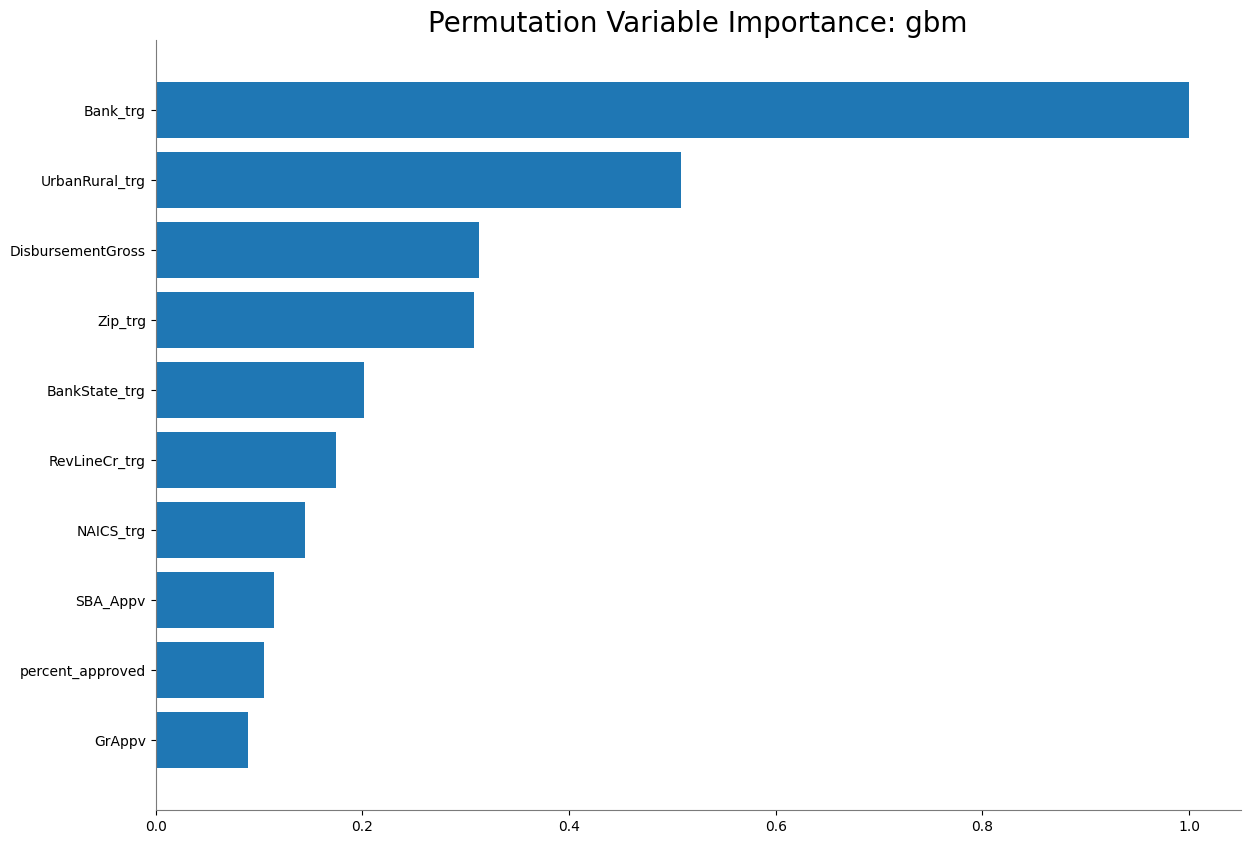

Variable Importances
Variable              Relative Importance    Scaled Importance    Percentage
--------------------  ---------------------  -------------------  ------------
Bank_trg              0.0774727              1                    0.321927
UrbanRural_trg        0.0394148              0.508757             0.163782
DisbursementGross     0.0242537              0.313062             0.100783
Zip_trg               0.0238294              0.307584             0.0990195
BankState_trg         0.0156398              0.201875             0.0649889
RevLineCr_trg         0.0135273              0.174607             0.0562107
NAICS_trg             0.0111551              0.143987             0.0463534
SBA_Appv              0.00887143             0.11451              0.036864
percent_approved      0.00814422             0.105124             0.0338421
GrAppv                0.00688744             0.0889015            0.0286198
State_trg             0.00632345             0.0816217            0.0262762
NoEmp                 0.00165649             0.0213816            0.00688329
RetainedJob           0.00151339             0.0195345            0.00628869
NewExist_trg          0.0009459              0.0122095            0.00393055
LowDoc_trg            0.00044444             0.00573673           0.00184681
City_trg              0.000236891            0.00305774           0.000984367
CreateJob             0.000177144            0.00228654           0.000736098
LoanInd               0.000149898            0.00193485           0.00062288
Franchise_Exists_trg  9.84774e-06            0.000127112          4.09208e-05
BalanceGross          0                      0                    0

In [ ]:
# plot permutation importance (bar plot)
best_model.permutation_importance_plot(val_data_h20)

Looking Overall, the Bank, ZIP and Urban_Rural are the top 3 things to lookout for while decicding on wheather to give a loan or not. Industry to which the loan belongs to i.e NAICS, State to which the Bank belongs, and Revolving line of credit attributes well to predict the defaulters.

In [ ]:
def examine_all_reason_codes(data, model):

    shap_contribs = model.predict_contributions(data)

    col_mapping = {}
    for i in data.col_names:
        related_cols = [x for x in shap_contribs.col_names if "{}.".format(i) in x]
        if len(related_cols) > 0:
            col_mapping[i] = related_cols

    for k, v in col_mapping.items():
        if len(v) > 1:
            shap_contribs[k] = shap_contribs[v].sum(axis=1,return_frame=True)
            shap_contribs = shap_contribs.drop(v)

    shap_cols = [i for i in shap_contribs.col_names if i != "BiasTerm"]
    bias_term = shap_contribs.as_data_frame()["BiasTerm"].values

    #Convert to Pandas DF
    X = data.as_data_frame(use_pandas=True)
    shap_contribs = shap_contribs.as_data_frame(use_pandas=True)

    return shap.summary_plot(shap_contribs[shap_cols].values,
                             X[shap_cols].values,
                             feature_names=shap_cols,
                             alpha=0.2
                            )

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


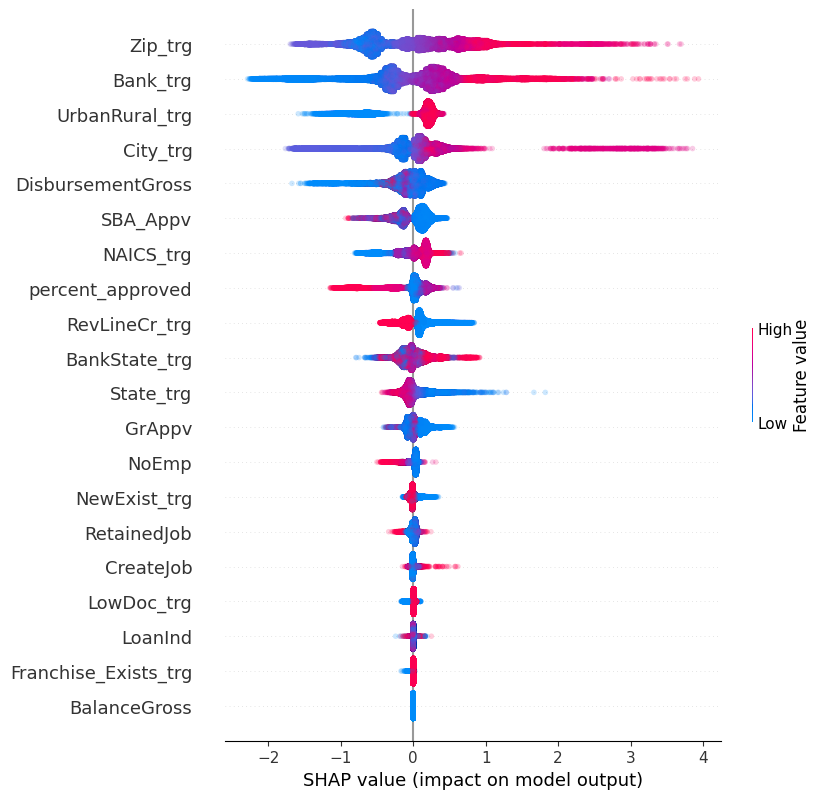

In [ ]:
examine_all_reason_codes(val_data_h20, best_model)

The ZIP, Bank as expected from the previous observations have a high impact on the model output.

BalanceGross as the least impact on the output, which can be attributed to the fact that all its information is already present in "GrAppv" and DisbursementGross, i.e their difference is BalanceGross.Also,there are only 6 Non-Zero values in this column in the entire dataset.

In [ ]:
def examine_indiv_reason_codes(record, model, use_matplotlib=True):

    shap_contribs = model.predict_contributions(record)

    col_mapping = {}
    for i in record.col_names:
        related_cols = [x for x in shap_contribs.col_names if "{}.".format(i) in x]
        if len(related_cols) > 0:
            col_mapping[i] = related_cols

    for k, v in col_mapping.items():
        if len(v) > 1:
            shap_contribs[k] = shap_contribs[v].sum(axis=1,return_frame=True)
            shap_contribs = shap_contribs.drop(v)

    shap_cols = [i for i in shap_contribs.col_names if i != "BiasTerm"]
    bias_term = shap_contribs.as_data_frame()["BiasTerm"].values
    X = record.as_data_frame(use_pandas=True)
    shap_contribs = shap_contribs.as_data_frame(use_pandas=True)

    return shap.force_plot(bias_term,
                           shap_contribs[shap_cols].values,
                           X[shap_cols].values,
                           shap_cols,
                           link="logit",
                           matplotlib=use_matplotlib
                          )

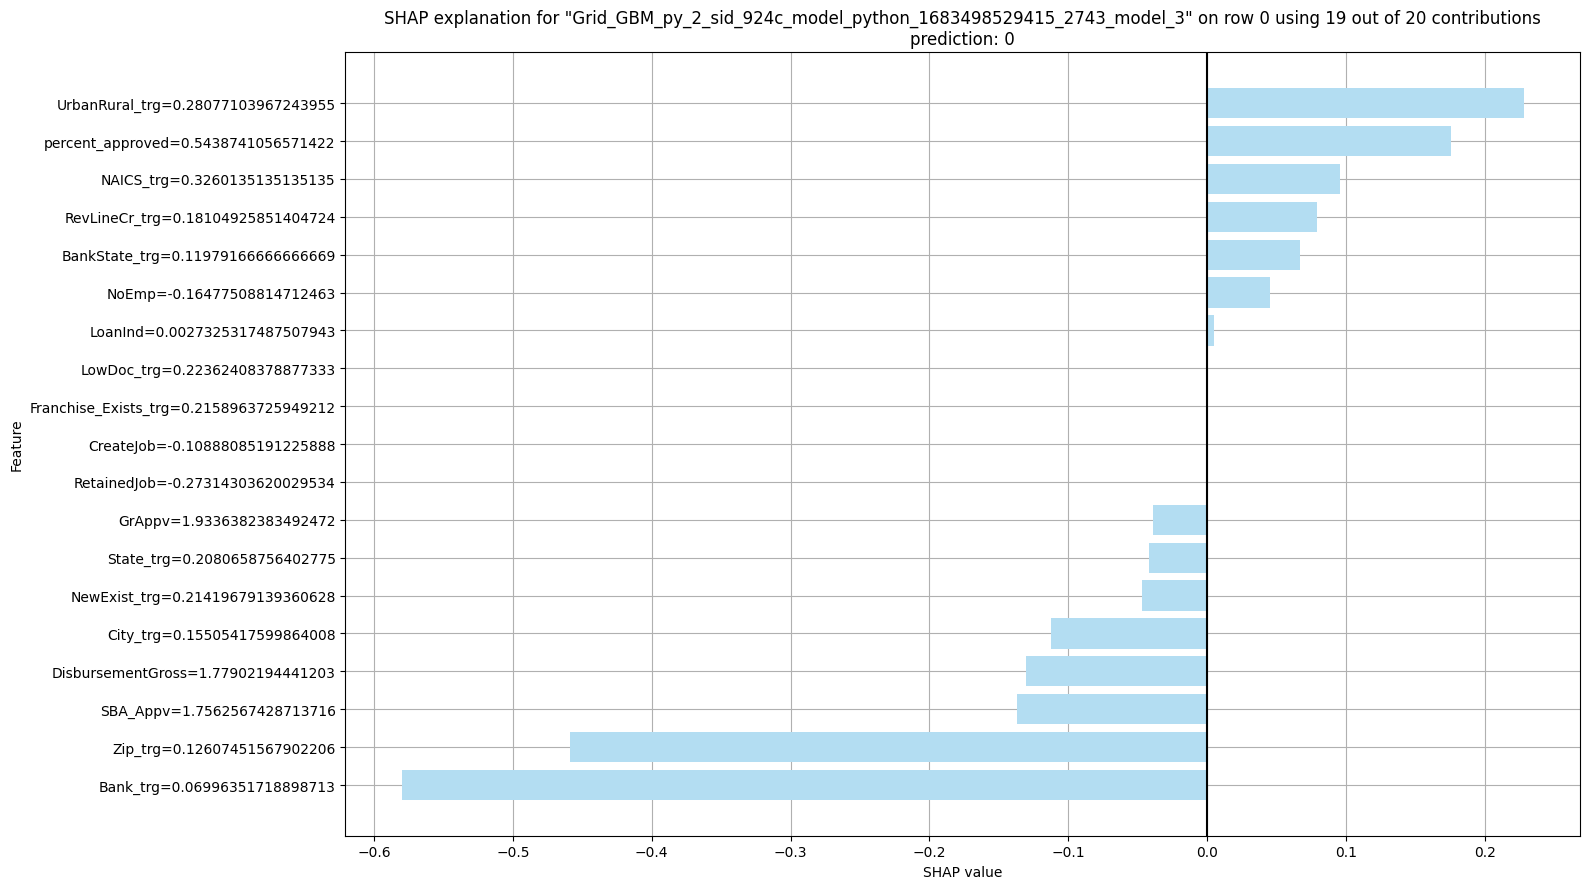

In [ ]:
best_model.shap_explain_row_plot(val_data_h20, row_index=0)

For this instance, the Bank and the ZIP had a strong impact ( negatively in this case) as expected from previous observation that these are highly influential variables.

And the other high impact variable Urban_Rural also hight impact (positively in this case).

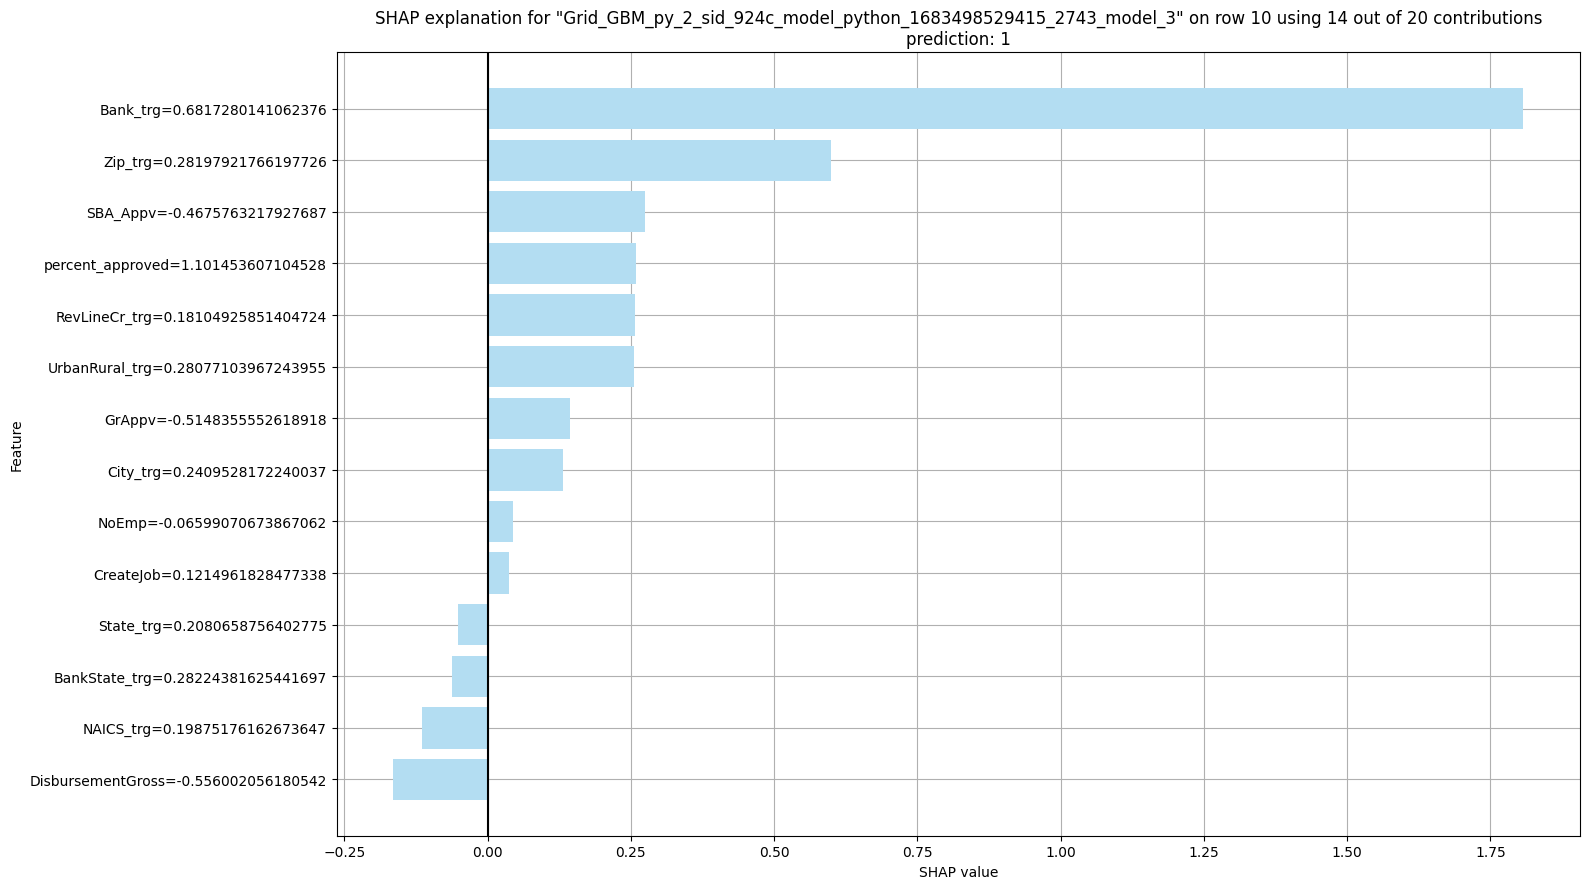

In [ ]:
best_model.shap_explain_row_plot(val_data_h20, row_index=10)

#In this instance, the same Bank and the ZIP played very high impact positively.

#NAICS, a negative impact which might indicate attribute of that certain industry. This can be checked by looking up at the corresponding NAICS two Value to the industry.


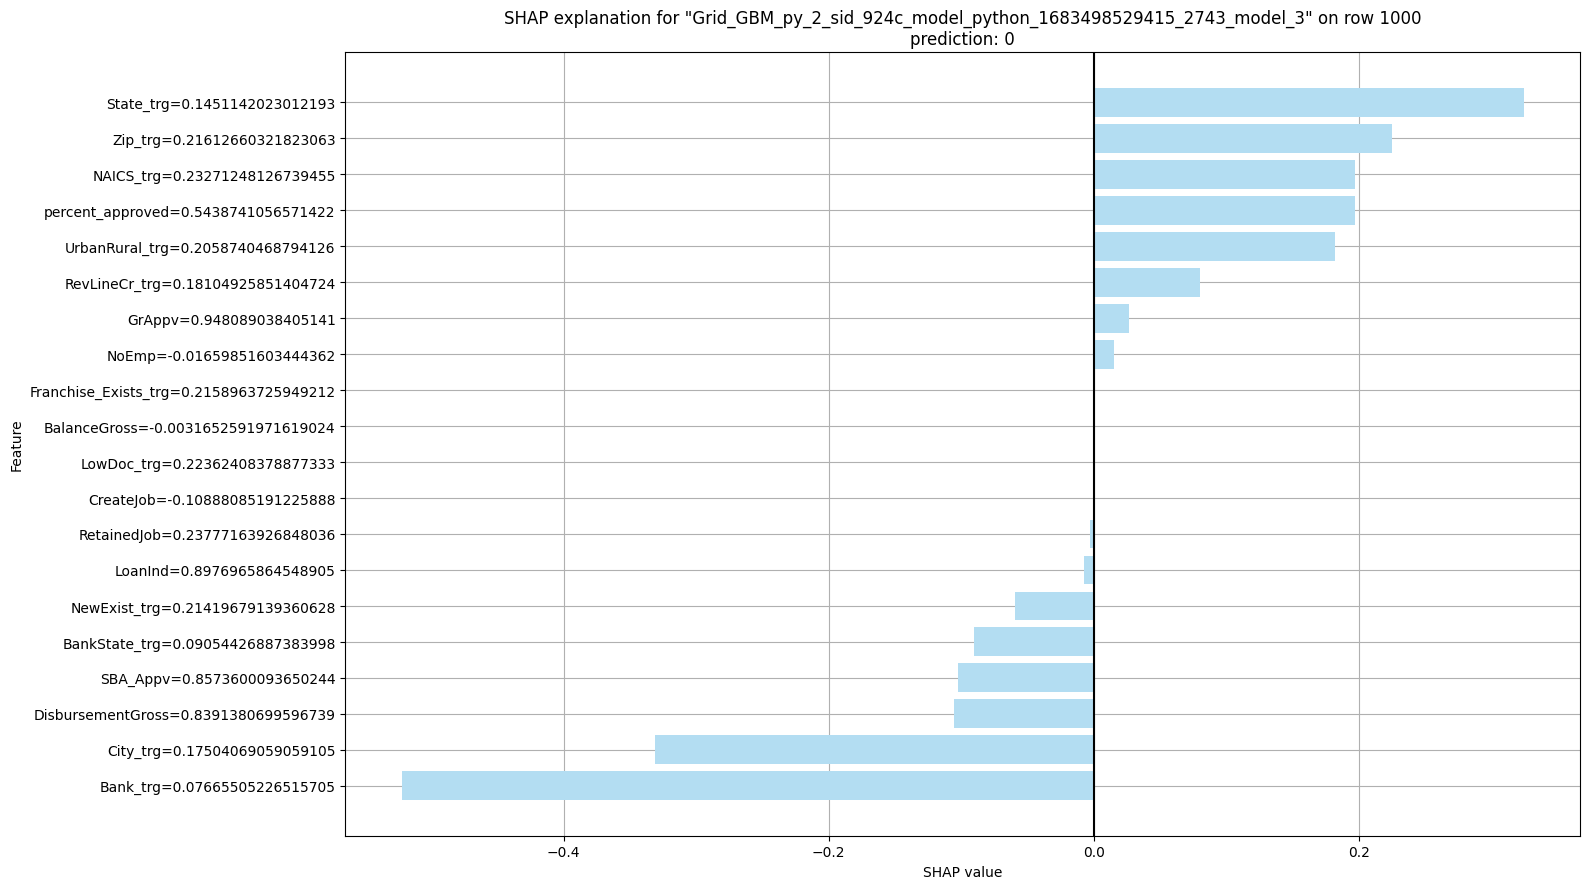

In [ ]:
best_model.shap_explain_row_plot(val_data_h20, row_index=1000)

The above mentioned assumptions are further reinforced by this instance. i.e in these  instances Bank, ZIP, Urbal_Rural, NAICS,         percent_approved, RevLineCr, BankState are showing strong ividences of their impact on the loan being defaulted or not.

#Evaluate performance on test data

In [ ]:
perf_test = best_model.model_performance(test_data_h20)

print("Best Model Hyperparameters:")
print(best_model.actual_params)

print("Best Model Performance:")
print(perf_test)

Best Model Hyperparameters:
{'model_id': 'Grid_GBM_py_2_sid_924c_model_python_1683498529415_2743_model_3', 'training_frame': 'py_2_sid_924c', 'validation_frame': None, 'nfolds': 0, 'keep_cross_validation_models': True, 'keep_cross_validation_predictions': False, 'keep_cross_validation_fold_assignment': False, 'score_each_iteration': False, 'score_tree_interval': 0, 'fold_assignment': None, 'fold_column': None, 'response_column': 'MIS_Status', 'ignored_columns': None, 'ignore_const_cols': True, 'offset_column': None, 'weights_column': None, 'balance_classes': False, 'class_sampling_factors': None, 'max_after_balance_size': 5.0, 'max_confusion_matrix_size': 20, 'ntrees': 150, 'max_depth': 5, 'min_rows': 10.0, 'nbins': 20, 'nbins_top_level': 1024, 'nbins_cats': 1024, 'r2_stopping': 1.7976931348623157e+308, 'stopping_rounds': 6, 'stopping_metric': 'logloss', 'stopping_tolerance': 0.001, 'max_runtime_secs': 0.0, 'seed': 5551167424965331728, 'build_tree_one_node': False, 'learn_rate': 0.1, '

Therefore, F1 score is 0.52 at  a max probability threshold of 0.27, the accuracy is 0.8132,and AUC is 0.79 on test dataset.

#Saving Scaling, Target encoding and Best Model

In [ ]:
import pickle

# Saving the scaler, target encoder
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

with open('target_encoder.pkl', 'wb') as file:
    pickle.dump(target_encoder, file)

In [ ]:
#saving best model
h2o.save_model(best_model, "best_model_path")



'C:\\Users\\axk220013\\Downloads\\best_model_path\\Grid_GBM_py_2_sid_924c_model_python_1683498529415_2743_model_3'